In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [2]:
url='https://drive.google.com/uc?id=1KE4cPt0l4vSm_OzuPNCf64BxMG_fygFL'
df = pd.read_csv(url, delimiter=';')

In [3]:
df

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,-99.99,317.10
4,1958,7,1958.542,315.86,315.86
...,...,...,...,...,...
701,2016,8,2016.625,402.25,402.25
702,2016,9,2016.708,401.03,401.03
703,2016,10,2016.792,401.57,401.57
704,2016,11,2016.875,403.53,403.53


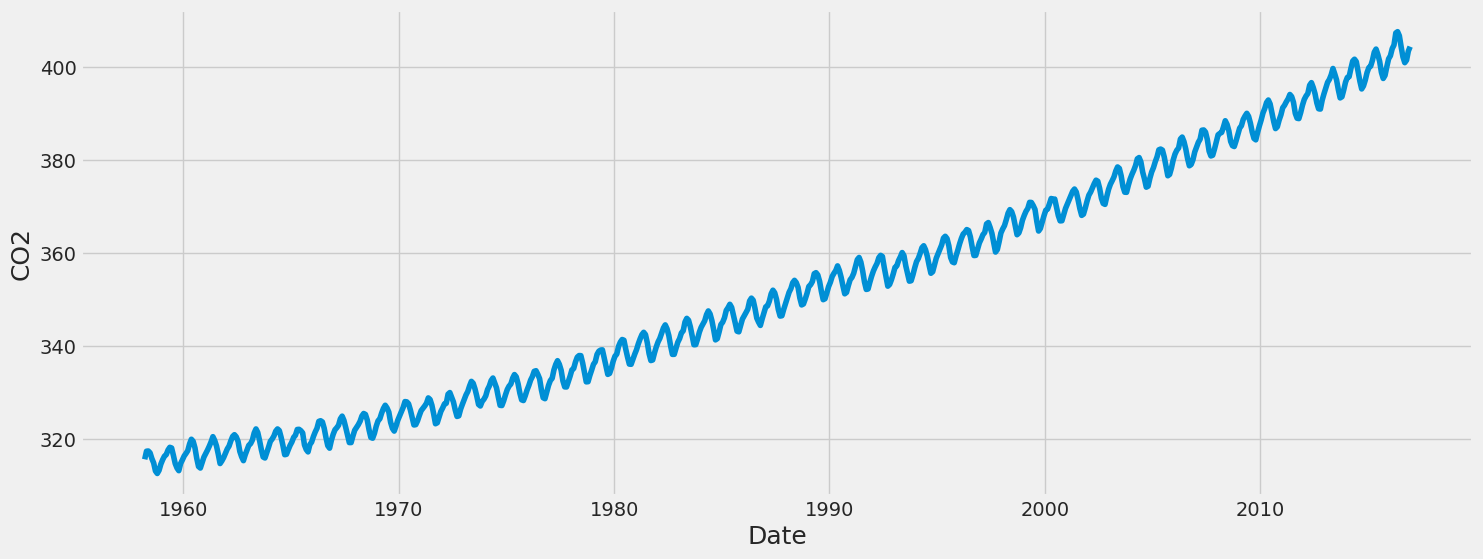

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(df['decimal_date'], df['interpolated'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('CO2', fontsize=18)
plt.show()

In [4]:
data = df.filter(['interpolated'])
data_time = df.filter(['decimal_date'])
dataset = data.values

In [5]:
training_data_len = int(np.ceil(len(dataset) * .95 ))
training_data_len

671

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [ ]:
train_data = scaled_data[:int(training_data_len), :]
x_train = []
y_train = []
lock = 60
for i in range(lock, len(train_data)):
    x_train.append(train_data[i - lock:i, 0])
    y_train.append(train_data[i, 0])
    if i<= lock:
        print(x_train)
        print(y_train)
        print()
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.03209175, 0.05039983, 0.05092593, 0.04671717, 0.03367003,
       0.02388468, 0.00568182, 0.        , 0.00704966, 0.02114899,
       0.03114478, 0.03914141, 0.04261364, 0.05324074, 0.05923822,
       0.05776515, 0.04082492, 0.02251684, 0.01241582, 0.00631313,
       0.02251684, 0.03072391, 0.03966751, 0.04534933, 0.05176768,
       0.06691919, 0.0775463 , 0.07291667, 0.05808081, 0.03419613,
       0.01578283, 0.01231061, 0.02462121, 0.03714226, 0.04492845,
       0.0530303 , 0.06186869, 0.07175926, 0.08333333, 0.07481061,
       0.06218434, 0.04345539, 0.02251684, 0.02861953, 0.03619529,
       0.0457702 , 0.05555556, 0.06207912, 0.07386364, 0.08385943,
       0.08785774, 0.08301768, 0.07281145, 0.04987374, 0.03787879,
       0.0290404 , 0.0424032 , 0.05292508, 0.06397306, 0.06755051])]
[0.07575757575757569]



In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(128, return_sequences=False))
model.add(Dense(32))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=5)

Epoch 1/5
611/611 [==============================] - 80s 124ms/step - loss: 0.0035
Epoch 2/5
611/611 [==============================] - 74s 121ms/step - loss: 9.2952e-04
Epoch 3/5
611/611 [==============================] - 74s 122ms/step - loss: 2.8177e-04
Epoch 4/5
611/611 [==============================] - 75s 123ms/step - loss: 9.8804e-04
Epoch 5/5
611/611 [==============================] - 74s 122ms/step - loss: 2.7870e-04


In [ ]:
test_data = scaled_data[training_data_len - lock: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(lock, len(test_data)):
    x_test.append(test_data[i - lock:i, 0])

x_test = np.array(x_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2/2 [==============================] - 0s 26ms/step


1.5706671226748177

In [7]:
train = data.loc[:training_data_len, :]
valid = data.loc[training_data_len:, :]
train_time = data_time.loc[:training_data_len, :]
valid_time = data_time.loc[training_data_len:, :]
valid.insert(1, 'predictions', predictions)

NameError: name 'predictions' is not defined

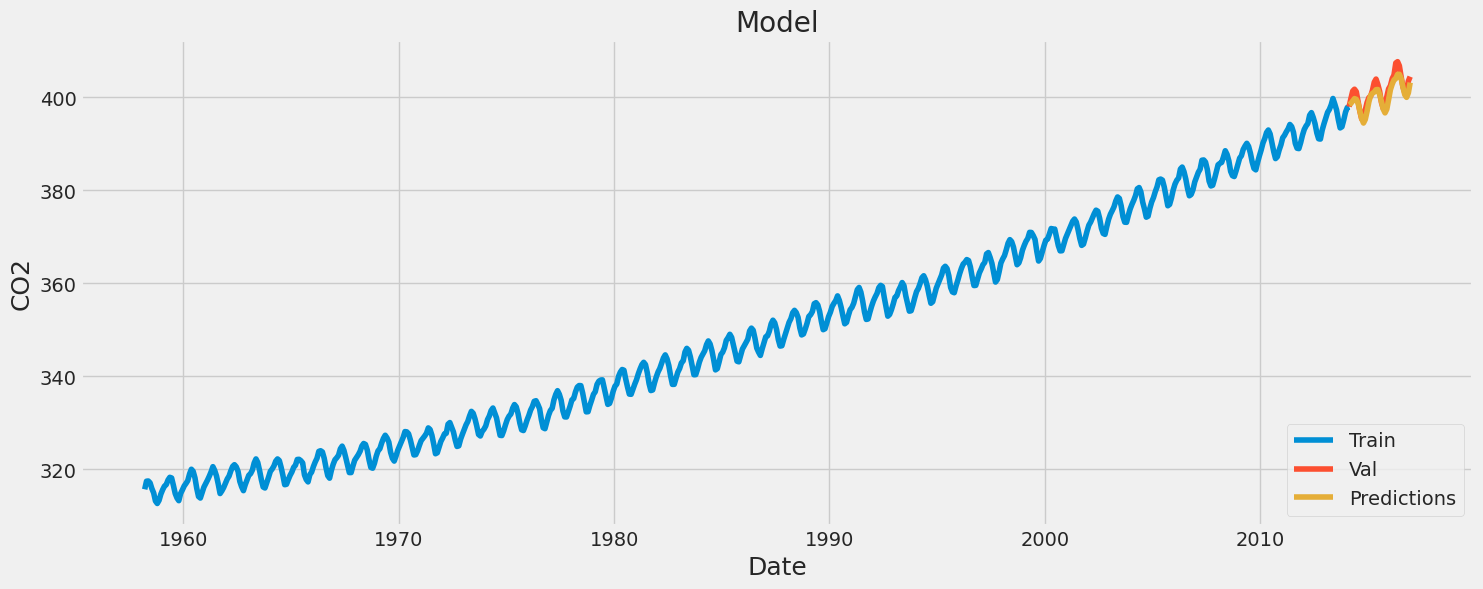

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('CO2', fontsize=18)
plt.plot(train_time,train)
plt.plot(valid_time,valid[['interpolated', 'predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()